# **Práctica NLP - Diciembre 2025 - Guillermo Barrio**

Esta es la práctica del módulo de NLP de Guillermo Barrio.

La práctica consta de tres notebooks:

- **Ejercicio 1** - Carga y visualización de datos
- **Ejercicio 2** - Preprocesado
- **Ejercicios 3 y 4** - Modelado, métricas y conclusiones

Como se observa, el tercer notebook incluye de facto los puntos 3 y 4 pedidos en el enunciado. En realidad, encuentro difícil separar el modelado de las métricas que producen los modelos, por lo que he preferido incluirlos en un mismo notebook.

**Inteligencia Artificial - DeepSeek y Colab** - He hecho uso de DeepSeek en muy contadas ocasiones, centradas en la fusión de los modelos de las columnas de 'title' y 'text', tanto para los modelos de ML como de los de Deep Learning, así como en la implementación del modelo preentrenado BERT. Por su parte, Colab, en más ocasiones, parecía adivinar mis intenciones, y una pequeña parte del código fue sugerida por él, y aceptada por mí.

**Datasets originales** - El repositorio de GitHub de esta práctica no me ha permitido subir los datasets originales descargados de la web con los reviews, al superar los 100 MiB de tamaño. Con todo, estos ficheros se pueden consultar en este [link](https://drive.google.com/drive/folders/1cQ7S7de2l8wQ8vkT4OZF0noPEqvEHOK5?usp=sharing):



# **Ejercicio 1 - Carga y visualización de datos**

Este es el Ejericio 1, centrado en la carga y visualización de datos. Hemos descargado tres datasets. Este ejercicio se divide en los siguientes puntos:

- Funciones utilizadas
- Carga de datos
- Rebalanceo y selección
- Cardinalidad
- Palabras más comunes
- N-gramas
- Word Cloud
- Ley de Zipf
- Vectorización TF-IDF, y análisis Chi2
- Vistazo a los embeddings

Comenzamos cargando las librerías de las que heremos uso en este notebook. He considerado una especie de standard para los tres ejercicios, pero solo cargo las necesarias en cada uno de ellos.

In [ ]:
import random
import numpy as np
import pandas as pd

# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

import matplotlib.pyplot as plt

In [ ]:
from nltk import ngrams
from nltk.probability import FreqDist

In [ ]:
from wordcloud import WordCloud

In [ ]:
import json

In [ ]:
import re

## Funciones utilizadas

Entiendo que es buena costrumbre el especificar al principio del notebook las funciones que hemos definido en él más adelante. En este caso son unas 10.

En general, comprobamos que yendo paso a paso obtenemos el resultado esperado, y a continuación unimos los pasos en una función. Repetiremos las funciones a lo largo del notebook, por lo que no es necesario el cargarlas ahora.

Load_data carga las columnas de los datos.

In [ ]:
def load_data(path):
  data = []

  with open(path, 'r', encoding = 'utf-8') as file:
      for line in file:
          # Parse each line as JSON
          item = json.loads(line)
          # Extract only the fields you need
          data.append({
              'title': item['title'],
              'text': item['text'],
              'rating': item['rating']
          })

  return pd.DataFrame(data)

clean_data reduce el peso de la categoría mayoritaria, el ratind de 5.

In [ ]:
def clean_data(df, number):
  rating_5 = df.loc[df['rating'] == 5].sample(number)
  df_comp = df.loc[df['rating'] != 5]
  df_balanced = pd.concat([df_comp, rating_5])
  return df_balanced

cardinalidad calcula la cardinalidad.

In [ ]:
def cardinalidad(series):

  text_list = series.tolist()
  text_total = ' '.join(text_list)
  # elimination of punctuation signs
  text_total = re.sub(r'[^\w\s]', '', text_total)
  # elimination of numbers
  text_total = re.sub(r'\d+', '', text_total)

  words_total = text_total.lower().split()
  wf = Counter(words_total)

  total_words = len(words_total)
  total_unique_words = len(wf)

  print(f'Número total de palabras: {total_words}')
  print(f'Número total de palabras únicas: {total_unique_words}')

plot_most_common dibuja las palabras (tokens) más comunes.

In [ ]:
def plot_most_common(df, n):
  text_list = df['text'].tolist()
  text_total = ' '.join(text_list)
  words_total = text_total.lower().split()

  wf = Counter(words_total)

  wf_most_common = wf.most_common(n)
  words = [w[0] for w in wf_most_common]
  freqs = [w[1] for w in wf_most_common]

  freqs, words = zip(*sorted(zip(freqs, words)))

  plt.barh(words, freqs)
  plt.xlabel('Frecuencia')
  plt.ylabel('Palabras')
  plt.title(f'Las {n} palabras más comunes')
  #plt.legend()
  plt.show()

n_grams devuelve los n_gramas más comunes y los encontrados primero.

In [ ]:
def n_grams(df, n, top):
  text_list = df['text'].tolist()
  text_total = ' '.join(text_list)
  words_total = text_total.lower().split()

  n_grams_ = list(ngrams(words_total, n))
  fd = FreqDist(n_grams_)

  return n_grams_[:top], fd.most_common(top)

plot_word_cloud dibuja el Word Cloud.

In [ ]:
def plot_word_cloud(df):
  text_list = df['text'].tolist()
  text_total = ' '.join(text_list)
  words_total = text_total.lower().strip().split()

  wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color="white").generate(' '.join(words_total))
  plt.figure(figsize=(12,6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

zipf dibuja el gráfico LogLog de frecuencia de palabras.

In [ ]:
def zipf(df):
  text_list = df['text'].tolist()
  text_total = ' '.join(text_list)
  words_total = text_total.lower().split()

  fd = FreqDist(words_total)

  fd = {k: v for k, v in sorted(fd.items(), key=lambda item: item[1], reverse=True)}

  ranks = list()
  freqs = list()

  for rank, word in enumerate(fd):
    ranks.append(rank+1)
    freqs.append(fd[word])

  plt.loglog(ranks, freqs)
  plt.xlabel('Rank')
  plt.ylabel('Freq')
  plt.title('Log-Log rank-freq chart')
  plt.show()

find_idf devuelve los vectores idf de una lista de palabras dada.

In [ ]:
def find_idf(df, words):

  cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2000,
    strip_accents='ascii',
    ngram_range=(1, 1) )

  cv.fit(df['text'])

  vocab_idf = dict(zip(cv.get_feature_names_out(), cv.idf_))

  print('{0:20}{1:20}'.format('Palabra', 'IDF'))
  for word in words:
      if word not in vocab_idf:
          print('{0:20}{1:20}'.format(word, 'OOV'))
      else:
          print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))


find_chi_2 dibuja el gráfico de las palabras con un chi cuadrado más significativo en función del rating.

In [ ]:
def find_chi_2(df, i):

  cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2000,
    strip_accents='ascii',
    ngram_range=(1, 1) )

  cv.fit(df['text'])

  X_trans = cv.transform(df['text'])

  chi2score = chi2(X_trans, df['rating'])[0]
  scores = list(zip(cv.get_feature_names_out(), chi2score))
  sorted_scores = sorted(scores, key=lambda x:x[1])
  topchi2 = list(zip(*sorted_scores[-i:]))
  x = range(len(topchi2[1]))
  labels = topchi2[0]

  plt.figure(figsize=(8, 6))
  plt.barh(x,topchi2[1], align='center', alpha=0.5)
  plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
  plt.yticks(x, labels, fontsize=12)
  plt.xlabel('$\chi^2$', fontsize=26)
  plt.ylabel('word', fontsize=16)
  plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
  plt.grid()
  plt.tight_layout()
  plt.show()


find_model_w2v devuelve el modelo entrenado de Word2Vec.

In [ ]:
def find_model_w2v(df, n):

  w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=200,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

  t = time()
  sent = [row.split() for row in df['text'][0:n]]
  w2v_model.build_vocab(sent, progress_per=10000)

  print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))
  print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.key_to_index)))

  t = time()

  w2v_model.train(sent, total_examples = w2v_model.corpus_count, epochs = 15, report_delay = 1)
  print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

  return w2v_model

## Carga de datos

Comenzamos con la descarga de datos. En el link de la página web del enunciado encontramos una serie de datasets de reviews. Algunos son demasiado grandes, pero otros son más o menos manejables. Hemos elegido tres de un tamaña creemos que aceptable para descargarlos enteros.

Tras descargar los tres datasets en mi PC local, y pasarlos a Drive, los descargamos ahora en este notebook, fila a fila, tomando tres columnas: 'title', 'text' y 'rating'. La columna de 'title' la tomamos también porque puede ser interesante analizarla también, al contener, al menos en teoría, información útil para determinar el sentimiento del review.

In [ ]:
data = []

path = '/content/drive/MyDrive/Practica_NLP_25/Project/Digital_Music.jsonl'

with open(path, 'r', encoding = 'utf-8') as file:
    for line in file:
        # Parse each line as JSON
        item = json.loads(line)
        # Extract only the fields you need
        data.append({
            'title': item['title'],
            'text': item['text'],
            'rating': item['rating']
        })


Vemos que en el caso del dataset de música digital contamos con unas 130 mil filas.

In [ ]:
df_rating = pd.DataFrame(data)

In [ ]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130434 entries, 0 to 130433
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   title   130434 non-null  object 
 1   text    130434 non-null  object 
 2   rating  130434 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.0+ MB


Para poder cargas los tres datasets definimos la función load_data, que nos devuelve ya un dataframe de Pandas.

In [ ]:
def load_data(path):
  data = []

  with open(path, 'r', encoding = 'utf-8') as file:
      for line in file:
          # Parse each line as JSON
          item = json.loads(line)
          # Extract only the fields you need
          data.append({
              'title': item['title'],
              'text': item['text'],
              'rating': item['rating']
          })

  return pd.DataFrame(data)

Vemos que aplicando la función obtenemos los mismos resultados que antes. Llamamos provisionalmente el dataset de digital 'rating'.

In [ ]:
df_rating = load_data('/content/drive/MyDrive/Practica_NLP_25/Project/Digital_Music.jsonl')

In [ ]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130434 entries, 0 to 130433
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   title   130434 non-null  object 
 1   text    130434 non-null  object 
 2   rating  130434 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.0+ MB


Vemos una muestra del dataset con .head()

In [ ]:
df_rating.head()

,title,text,rating
0,Nice,If i had a dollar for how many times I have pl...,5.0
1,Excellent,awesome sound - cant wait to see them in perso...,5.0
2,Great service,This is a great cd. Good music and plays well....,5.0
3,No good,"These are not real German singers, they have a...",1.0
4,"Cool concept, so-so execution...",I first heard this playing in a Nagoya shop an...,3.0


Vemos un ejemplo de review algo larga, que contiene elementos de html, en especial los cambios de párrafo, que habrá que eliminar en el preprocesado.

In [ ]:
df_rating.iloc[5,1]

'I just saw "Star Wars: L\'attaque des clones" last night (in Ste-Foy, Québec) at a sold-out show (it was playing in English at the theatre next door but I opted for the French version instead). First of all, the theatre itself was an experience: an immense screen that looked as large as an IMAX screen, intense surround THX sound, and the digital picture (even at that size) was amazingly crisp, the colours vibrant, and the sound effects were ear-splitting and exhilarating (especially the moments of silence that preceded the sonic depth charge explosions!)<br />I have seen the other four Star Wars movies but avoided reading publicity and reviews for "Attack of the Clones" in order to enjoy every moment without worrying over a particular critic\'s faults with the film. This film is much darker than "The Phantom Menace" could have ever aspired to be. Lucas has moved from stilted, juvenile scriptwriting on "TPM" to (still) stilted, mythological, more adult scriptwriting on "Attack of the C

Vemos la distribución de los ratings que, como cabía esperar, están sesgados hacia el 5. En este producto de música digital es de esperar, ya que las compras suelen ser de música que ya conoce, y gusta, al comprador.

In [ ]:
df_rating['rating'].value_counts()

,count
rating,
5.0,100618
4.0,14129
3.0,6392
1.0,6136
2.0,3159


Cargamos el dataset de salud y cuidado personal, que llamamos 'df_health'.

In [ ]:
df_health = load_data('/content/drive/MyDrive/Practica_NLP_25/Project/Health_and_Personal_Care.jsonl')

In [ ]:
df_health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494121 entries, 0 to 494120
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   title   494121 non-null  object 
 1   text    494121 non-null  object 
 2   rating  494121 non-null  float64
dtypes: float64(1), object(2)
memory usage: 11.3+ MB


De nuevo, este dataset está desbalanceado, aunque sea en menor intensidad que el de música digital.

In [ ]:
df_health['rating'].value_counts()

,count
rating,
5.0,301713
1.0,69564
4.0,57000
3.0,36949
2.0,28895


Cargamos el dataset de belleza, unas 700 mil filas.

In [ ]:
df_beauty = load_data('/content/drive/MyDrive/Practica_NLP_25/Project/All_Beauty.jsonl')

In [ ]:
df_beauty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   title   701528 non-null  object 
 1   text    701528 non-null  object 
 2   rating  701528 non-null  float64
dtypes: float64(1), object(2)
memory usage: 16.1+ MB


Sin sorpresas, el dataset de belleza se halla desbalanceado también.

In [ ]:
df_beauty['rating'].value_counts()

,count
rating,
5.0,420726
1.0,102080
4.0,79381
3.0,56307
2.0,43034


## Rebalanceo y selección

En este apartado pasamos a rebalancear y seleccionar un número de filas menor en cada dataset al te tenemos de momento. Haremos esto en dos pasos:

- Nos quedamos con un número aceptable de reviews con el rating 5
- Después seleccionamos un número de filas del total de dataset ya rebalanceado, que hemos fijado en 30.000.


Mostramos el proceso paso a paso con el dataset de belleza (beauty). Viendo el número de filas que tienen los ratigs de 1 a 4, pensamos que uno aceptable para el rating 5 sería 80.000.

In [ ]:
number = 80000

Seleccionamos 80.000 filas con rating 5, y hacemos un concat (fusión) con los ratings que no son 5, creando el dataset 'df_beauty_balaced'

In [ ]:
rating_5 = df_beauty.loc[df_beauty['rating'] == 5].sample(number)

In [ ]:
df_beauty_comp = df_beauty.loc[df_beauty['rating'] != 5]

In [ ]:
df_beauty_balanced = pd.concat([df_beauty_comp, rating_5])

In [ ]:
df_beauty_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360802 entries, 1 to 415940
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   title   360802 non-null  object 
 1   text    360802 non-null  object 
 2   rating  360802 non-null  float64
dtypes: float64(1), object(2)
memory usage: 11.0+ MB


Vemos ahora que, sin ser perfecto, el dataset está algo más rebalanceado.

In [ ]:
df_beauty_balanced['rating'].value_counts()

,count
rating,
1.0,102080
5.0,80000
4.0,79381
3.0,56307
2.0,43034


La media de los ratings está cercana a 3, la esperada en el caso de un dataset rebalancesado perfectamente.

In [ ]:
np.mean(df_beauty_balanced['rating'])

np.float64(2.9783454637169418)

Creamos una función que haga el rebalanceo automáticamente, clean_data...

In [ ]:
def clean_data(df, number):
  rating_5 = df.loc[df['rating'] == 5].sample(number)
  df_comp = df.loc[df['rating'] != 5]
  df_balanced = pd.concat([df_comp, rating_5])
  return df_balanced

... y la aplicamos a los tres datasets.

In [ ]:
df_beauty_balanced = clean_data(df_beauty, number)

In [ ]:
df_health_balanced = clean_data(df_health, 65000)

In [ ]:
df_digital_balanced = clean_data(df_rating, 7000)

Ve,os que la media no se aleja mucho de 3.

In [ ]:
print(np.mean(df_beauty_balanced['rating']))
print(np.mean(df_health_balanced['rating']))
print(np.mean(df_digital_balanced['rating']))

2.9783454637169418
3.0737234273993037
3.3449043893959147


In [ ]:
df_beauty_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360802 entries, 1 to 404054
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   title   360802 non-null  object 
 1   text    360802 non-null  object 
 2   rating  360802 non-null  float64
dtypes: float64(1), object(2)
memory usage: 11.0+ MB


He tenido problemas en el caso de que los campos tengan como contenido 'None', me daba algún error tonto, por lo que es mejor eliminar estas filas. Se trata de muy pocas de todas formas.

In [ ]:
df_beauty_balanced.loc[df_beauty_balanced['text'] == 'None']

,title,text,rating
29389,None,None,4.0
34286,None,None,3.0
34289,None,None,3.0
54622,None,None,4.0
185509,None,None,3.0
294634,None,None,4.0
555365,One Star,None,1.0
673242,Too thin,None,1.0
700744,None,None,3.0
567036,Travel plastic bottle,None,5.0


Las elimino en los tres datasets.

In [ ]:
df_beauty_balanced = df_beauty_balanced.loc[df_beauty_balanced['text'] != 'None']
df_health_balanced = df_health_balanced.loc[df_health_balanced['text'] != 'None']
df_digital_balanced = df_digital_balanced.loc[df_digital_balanced['text'] != 'None']

In [ ]:
df_beauty_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360788 entries, 1 to 404054
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   title   360788 non-null  object 
 1   text    360788 non-null  object 
 2   rating  360788 non-null  float64
dtypes: float64(1), object(2)
memory usage: 11.0+ MB


Vemos algún ejemplo del texto de las reviews.

In [ ]:
text_list = df_beauty_balanced['text'].tolist()

In [ ]:
text_list[29389]

'nice. cheep but i expected that. like them.'

Ahora pasamos a seleccionar las 30.000 filas con las que nos quedaremos. Lo hacemos con la función sample() de Pandas.

In [ ]:
df_beauty_balanced = df_beauty_balanced.sample(30000, random_state = 42)
df_health_balanced = df_health_balanced.sample(30000, random_state = 42)
df_digital_balanced = df_digital_balanced.sample(30000, random_state = 42)

Como es de esperar, las medias de los ratings son las mismas prácticamente que antes.

In [ ]:
print(np.mean(df_beauty_balanced['rating']))
print(np.mean(df_health_balanced['rating']))
print(np.mean(df_digital_balanced['rating']))

2.9886333333333335
3.0838666666666668
3.3546


Ahora lo que hacemos es guardar los tres datasets ya balanceados, y reducidos a unas más razonables 30.000 filas.

In [ ]:
df_beauty_balanced.to_csv('/content/drive/MyDrive/Practica_NLP_25/Project/df_beauty_balanced.csv', index = False)
df_health_balanced.to_csv('/content/drive/MyDrive/Practica_NLP_25/Project/df_health_balanced.csv', index = False)
df_digital_balanced.to_csv('/content/drive/MyDrive/Practica_NLP_25/Project/df_digital_balanced.csv', index = False)

## Cardinalidad

Pasamos ahora a la visualización de los tres datasets. Comenzamos cargándolos, intentando que las columnas the 'text' y 'title' sean strings, para evitar errores.

In [ ]:
dtype = {'text': str, 'title': str}

In [ ]:
df_beauty_balanced = pd.read_csv('/content/drive/MyDrive/Practica_NLP_25/Project/df_beauty_balanced.csv', dtype = dtype, na_values = '')
df_health_balanced = pd.read_csv('/content/drive/MyDrive/Practica_NLP_25/Project/df_health_balanced.csv', dtype = dtype, na_values = '')
df_digital_balanced = pd.read_csv('/content/drive/MyDrive/Practica_NLP_25/Project/df_digital_balanced.csv', dtype = dtype, na_values = '')


In [ ]:
df_beauty_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   29998 non-null  object 
 1   text    29998 non-null  object 
 2   rating  30000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 703.3+ KB


Para mayor seguridad casteamos las columnas a string en los tres datasets.

In [ ]:
df_beauty_balanced['title'] = df_beauty_balanced['title'].astype(str)
df_beauty_balanced['text'] = df_beauty_balanced['text'].astype(str)
df_health_balanced['title'] = df_health_balanced['title'].astype(str)
df_health_balanced['text'] = df_health_balanced['text'].astype(str)
df_digital_balanced['title'] = df_digital_balanced['title'].astype(str)
df_digital_balanced['text'] = df_digital_balanced['text'].astype(str)

Comprobamos que podemos pasar sin problemas las columnas de los datasets a una lista, cosa que sin hacer el casteo teníamos problemas.

In [ ]:
text_list = df_beauty_balanced['text'].tolist()

In [ ]:
len(text_list)

30000

Comprobamos que tenemos las 30.000 columnas en los tres datasets.

In [ ]:
df_beauty_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   30000 non-null  object 
 1   text    30000 non-null  object 
 2   rating  30000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 703.3+ KB


In [ ]:
df_digital_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   30000 non-null  object 
 1   text    30000 non-null  object 
 2   rating  30000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 703.3+ KB


In [ ]:
df_health_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   30000 non-null  object 
 1   text    30000 non-null  object 
 2   rating  30000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 703.3+ KB


A continuación pasamos a considerar la cardinalidad de los datasets, en su columna de 'text'. He definido la función que lo hace, que incluye un mínimo preprocesado, que pusimos tras comprobar el alto número de palabras únicas que obteníamos. Con el preprocesado se reducen a la mitad. He de decir que el código de regex fue sugerido enteramente por Colab, realmente impresionante.

In [ ]:
def cardinalidad(series):

  text_list = series.tolist()
  text_total = ' '.join(text_list)
  # elimination of punctuation signs
  text_total = re.sub(r'[^\w\s]', '', text_total)
  # elimination of numbers
  text_total = re.sub(r'\d+', '', text_total)

  words_total = text_total.lower().split()
  wf = Counter(words_total)

  total_words = len(words_total)
  total_unique_words = len(wf)

  print(f'Número total de palabras: {total_words}')
  print(f'Número total de palabras únicas: {total_unique_words}')



Es curioso que en el caso del dataset de la música digital tenemos un vocabulario mucho más amplio que en los otros dos. Quizá sea porque los reviews son más largos, que lo son, y porque incluyan más nombres propios (NER).

In [ ]:
cardinalidad(df_beauty_balanced['text'])

Número total de palabras: 1039928
Número total de palabras únicas: 25031


In [ ]:
cardinalidad(df_health_balanced['text'])

Número total de palabras: 1119033
Número total de palabras únicas: 29071


In [ ]:
cardinalidad(df_digital_balanced['text'])

Número total de palabras: 2336192
Número total de palabras únicas: 88034


## Palabras más comunes

Pasamos a las palabras, o tokens, más comunes. Llevamos a cabo ello paso a paso en el caso del dataset de belleza, pasando la columna de 'text' a lista, y aplicando un mínimo preprocesado.

In [ ]:
from collections import Counter

In [ ]:
text_list = df_beauty_balanced['text'].tolist()

In [ ]:
text_total = ' '.join(text_list)

In [ ]:
words_total = text_total.lower().split()

In [ ]:
len(words_total)

1051947

Aplicamos la función de python Counter, y seleccionamos las 10 palabras que más se repiten.

In [ ]:
wf = Counter(words_total)

In [ ]:
wf_most_common = wf.most_common(10)

No es realmente una sorpresa que las palabras más comunes sean artículos y preposiciones.

In [ ]:
wf_most_common

[('the', 45433),
 ('i', 37213),
 ('and', 28354),
 ('it', 28329),
 ('to', 24766),
 ('a', 24409),
 ('is', 15113),
 ('this', 14971),
 ('my', 14845),
 ('for', 13473)]

Podemos dibujar las frecuencias en un diagrama de barras.

In [ ]:
words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]

In [ ]:
freqs, words = zip(*sorted(zip(freqs, words)))

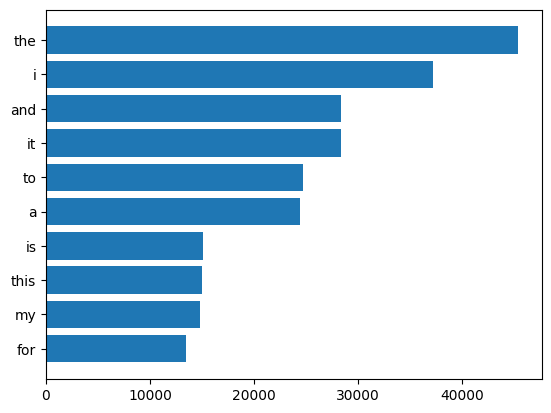

In [ ]:
plt.barh(words, freqs)
plt.show()

Ahora concentramos estos pasos en una sola función, a la que pasamos el dataframe que queremos examinar, y el número de palabras más comunes que mostramos.

In [ ]:
def plot_most_common(df, n):
  text_list = df['text'].tolist()
  text_total = ' '.join(text_list)
  words_total = text_total.lower().split()

  wf = Counter(words_total)

  wf_most_common = wf.most_common(n)
  words = [w[0] for w in wf_most_common]
  freqs = [w[1] for w in wf_most_common]

  freqs, words = zip(*sorted(zip(freqs, words)))

  plt.barh(words, freqs)
  plt.xlabel('Frecuencia')
  plt.ylabel('Palabras')
  plt.title(f'Las {n} palabras más comunes')
  #plt.legend()
  plt.show()

Lo cierto es que no hay mucha diferencia en el caso de los datasets de belleza y salud, de hecho son casi idénticos en este aspecto...

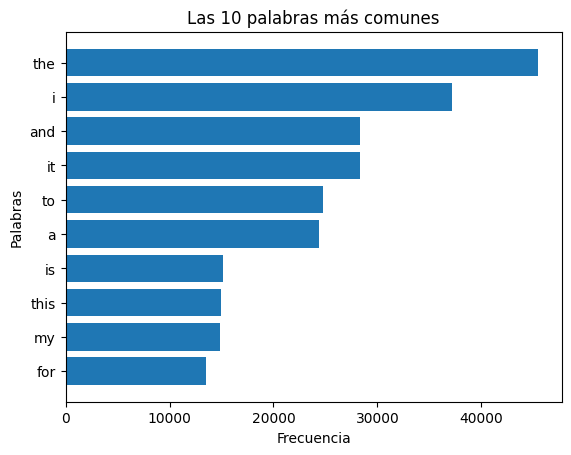

In [ ]:
plot_most_common(df_beauty_balanced, 10)

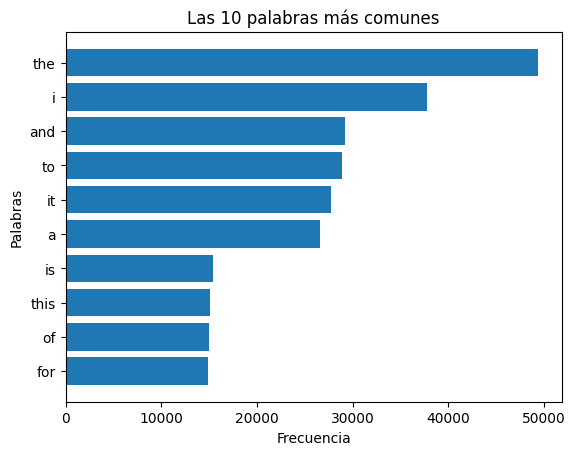

In [ ]:
plot_most_common(df_health_balanced, 10)

... pero en el caso de la música digital es curioso que la palabra 'the' saque tanta ventaja al resto, mientras que el prononbre 'I' no salga mucho. Quizás tenga que ver con que los productos de belleza y salud se aplican a uno mismo, el comprador, mientras que en el caso de la música el consumidor se limita a oirla, siendo el contacto, digamos, menos intenso, Quién sabe.

De todas formas, se trata de palabras que no aportan apenas significado, y que eliminaremos con los stop words en el notebook (ejercicio) siguiente.

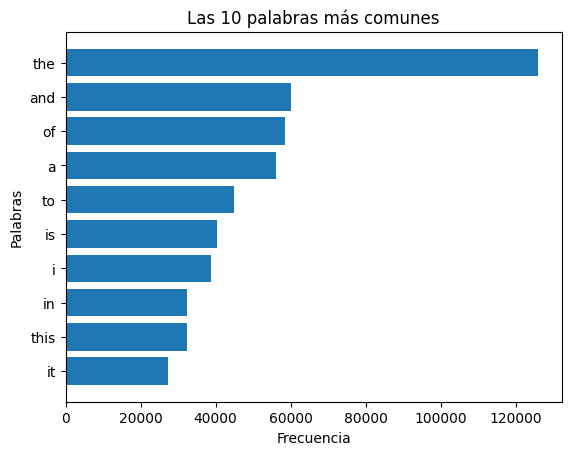

In [ ]:
plot_most_common(df_digital_balanced, 10)

## N-gramas

Pasamos a los n-gramas. Utilizamos las funciones que nos da la librería NLTK, y hemos definido una función bastante sencilla, n_gram, que las calcula, en función de su longitud y el parámetro 'top', que da las primeras que encuentra y las más comunes. Usamos la función FredDist() para calcular las frecuencias.

In [ ]:
def n_grams(df, n, top):
  text_list = df['text'].tolist()
  text_total = ' '.join(text_list)
  words_total = text_total.lower().split()

  n_grams_ = list(ngrams(words_total, n))
  fd = FreqDist(n_grams_)

  return n_grams_[:top], fd.most_common(top)

Empezamos con el dataset de belleza 'df_beauty_balanced', con los 10 n-grams de dos palabras más comunes y que primero encuentra.

In [ ]:
n_grams_first, n_grams_ = n_grams(df_beauty_balanced, 2, 10)

In [ ]:
n_grams_first

[('i', 'have'),
 ('have', 'been'),
 ('been', 'looking'),
 ('looking', 'for'),
 ('for', 'a'),
 ('a', 'hook'),
 ('hook', 'body'),
 ('body', 'wash'),
 ('wash', 'holder'),
 ('holder', 'for')]

Sin grandes sorpresas, los n-gramas más comunes se componen de palabras que serán eliminadas: pronombres, artículos y preposiciones, que no aportan realmente valor.

In [ ]:
n_grams_

[(('of', 'the'), 3157),
 (('i', 'have'), 2859),
 (('in', 'the'), 2469),
 (('it', 'is'), 2371),
 (('it', 'was'), 2232),
 (('i', 'was'), 2120),
 (('and', 'i'), 1932),
 (('and', 'the'), 1905),
 (('this', 'is'), 1896),
 (('and', 'it'), 1841)]

In [ ]:
n_grams_first, n_grams_ = n_grams(df_health_balanced, 2, 10)

In [ ]:
n_grams_first

[('i', 'received'),
 ('received', 'my'),
 ('my', 'scale'),
 ('scale', 'and'),
 ('and', 'i'),
 ('i', 'can'),
 ('can', 'weigh'),
 ('weigh', 'myself'),
 ('myself', 'once'),
 ('once', 'then')]

En el caso del dataset de salud, al menos encontramos la palabra 'product', que podria sernos útil.

In [ ]:
n_grams_

[(('of', 'the'), 3371),
 (('in', 'the'), 3070),
 (('i', 'have'), 3022),
 (('it', 'is'), 2464),
 (('on', 'the'), 2255),
 (('i', 'was'), 2025),
 (('it', 'was'), 1964),
 (('this', 'is'), 1909),
 (('and', 'i'), 1895),
 (('this', 'product'), 1860)]

In [ ]:
n_grams_first, n_grams_ = n_grams(df_digital_balanced, 2, 10)

In [ ]:
n_grams_first

[('the', 'description'),
 ('description', 'clearly'),
 ('clearly', 'states'),
 ('states', 'that'),
 ('that', 'it’s'),
 ('it’s', 'a'),
 ('a', 'factory'),
 ('factory', 'sealed'),
 ('sealed', 'cd.'),
 ('cd.', 'it’s')]

En el caso del dataset de música digital, no hay diferencias respecto al resto,más allá de comprobar que la palabra tan común 'the' aparece en los n-gramas más repetidos.

In [ ]:
n_grams_

[(('of', 'the'), 16053),
 (('in', 'the'), 8591),
 (('is', 'a'), 6321),
 (('on', 'the'), 5316),
 (('this', 'is'), 5232),
 (('and', 'the'), 4902),
 (('to', 'the'), 4459),
 (('it', 'is'), 4198),
 (('for', 'the'), 3622),
 (('with', 'the'), 3462)]

Quizás como curiosidad, si pasamos a la función una longitud de 1, obtenemos la frecuencia de las palabras.

In [ ]:
n_grams_first, n_grams_ = n_grams(df_beauty_balanced, 1, 10)

In [ ]:
n_grams_

[(('the',), 45433),
 (('i',), 37213),
 (('and',), 28354),
 (('it',), 28329),
 (('to',), 24766),
 (('a',), 24409),
 (('is',), 15113),
 (('this',), 14971),
 (('my',), 14845),
 (('for',), 13473)]

## Word Cloud

Pasamos al Word Cloud, una forma muy gráfica de ver qué palabras son más comunes. Hemos utilizado, adaptada, la función que vimos en clase, en general con los mismos parámetros, que llamamos 'plot_word_cloud'

In [ ]:
def plot_word_cloud(df):
  text_list = df['text'].tolist()
  text_total = ' '.join(text_list)
  words_total = text_total.lower().strip().split()

  wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color="white").generate(' '.join(words_total))
  plt.figure(figsize=(12,6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

Vemos en el cloud del dataset de belleza palabras como 'scent' que significa olor, o hair (pelo), aparte de las más comunes que ya hemos descubierto. La palabra 'br' es sin duda la de cambio de párrafo en html, que tendremos que eliminar.

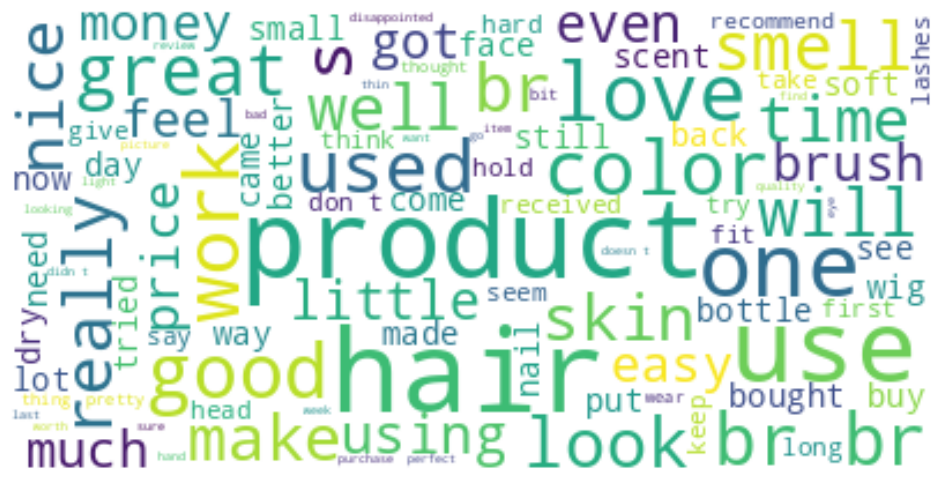

In [ ]:
plot_word_cloud(df_beauty_balanced)

En el caso del dataset de música digital encontramos palabras como 'song', o 'sound', lo cual no es ninguna sorpresa.

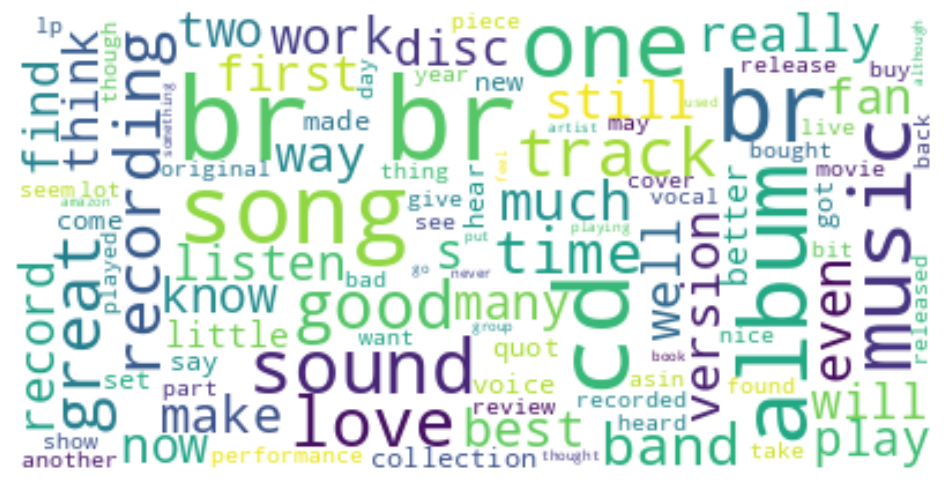

In [ ]:
plot_word_cloud(df_digital_balanced)

Finalmente en el dataset de salud aparcen palabras como 'work' o 'using', sin grandes sorpresas tampoco.

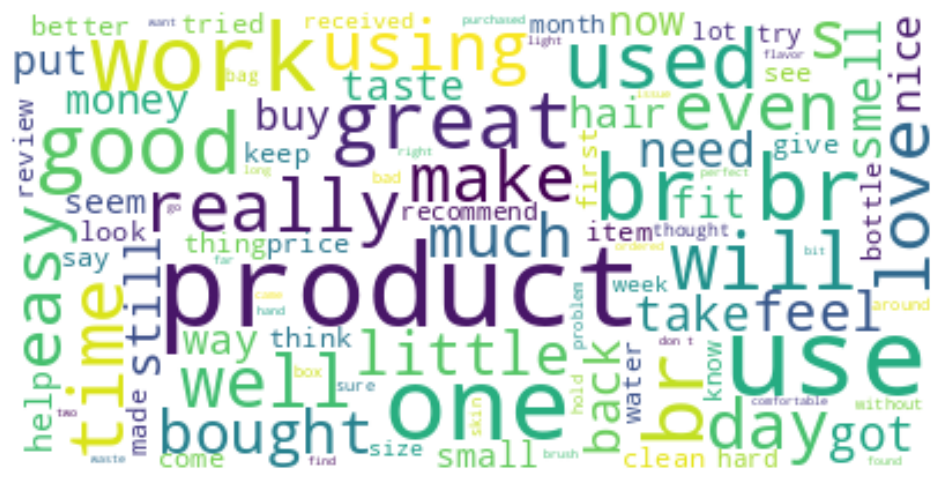

In [ ]:
plot_word_cloud(df_health_balanced)

## Ley de Zipf

Ahora, para comprobar la Ley de Zipf, hacemos uso de la función que vimos en clase, zipf, que utiliza a su vez el FreqDist() de NLTK. Llevamos a cabo también dentro de ella un pequeño preprocesamiento, pasando las palabras a minúsculas.

In [ ]:
def zipf(df):
  text_list = df['text'].tolist()
  text_total = ' '.join(text_list)
  words_total = text_total.lower().split()

  fd = FreqDist(words_total)

  fd = {k: v for k, v in sorted(fd.items(), key=lambda item: item[1], reverse=True)}

  ranks = list()
  freqs = list()

  for rank, word in enumerate(fd):
    ranks.append(rank+1)
    freqs.append(fd[word])

  plt.loglog(ranks, freqs)
  plt.xlabel('Rank')
  plt.ylabel('Freq')
  plt.title('Log-Log rank-freq chart')
  plt.show()

En el caso de la música digital, obtenemos una recta casi perfecta en el cuadro LogLog, por lo que el dataset obedece fielmente la Ley de Zipf, quizá ayudada por la gran cantidad de palabras diferentes que contiene, cerca de 90.000.

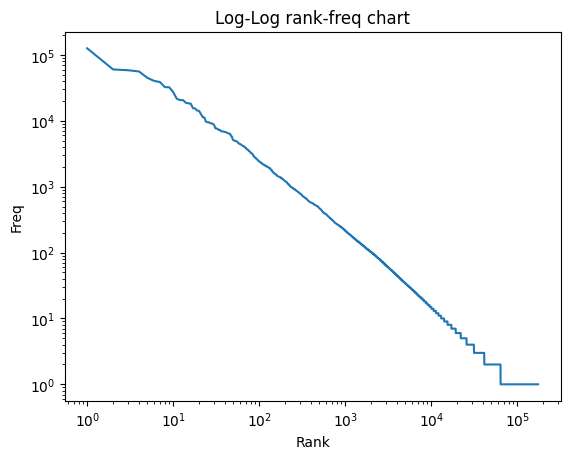

In [ ]:
zipf(df_digital_balanced)

En los otros dos datasets, la correspondencia de su vocabulario con la Ley de Zipf es buena, pero no tanto como en el de la música digital, sin duda debido a que contienen un vocabulario más pequeño, pero de todas formas notable, de cerca de 30.000 palabras en ambos casos.

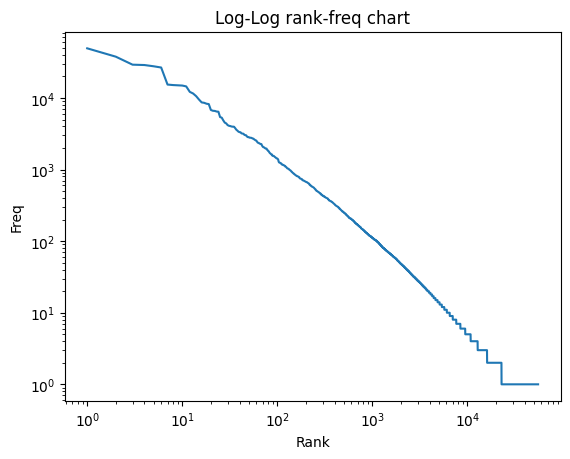

In [ ]:
zipf(df_health_balanced)

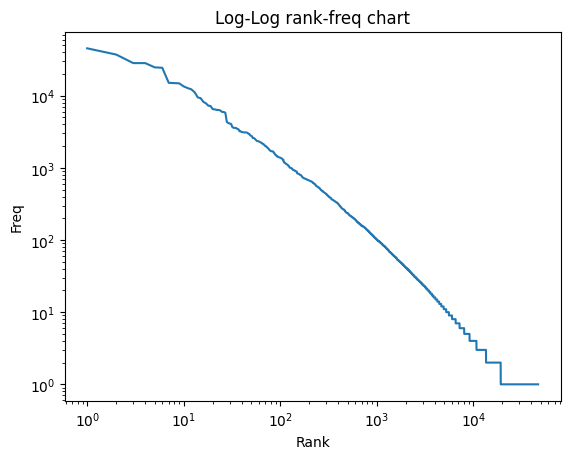

In [ ]:
zipf(df_beauty_balanced)

## Vectorización TFIDF y análisis Chi2

Estudiamos ahora la vectorización por TFIDF como tal, y desde un punto de vista de la visualización, el aplicarla a la distribución Chi cuadrado para ver qué palabras son, en principio, más influyentes en el sentimiento de las reviews.

Podemos comenzar instanciando un objeto de la librería TfidfVectorizer(), considerando las 2.000 palabras más relevantes.

In [ ]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2000,
    strip_accents='ascii',
    ngram_range=(1, 1)
)

Entrenamos el objeto con la columna de 'text' del dataset de música digital.

In [ ]:
cv.fit(df_digital_balanced['text'])

TfidfVectorizer(max_df=0.95, max_features=2000, min_df=5, strip_accents='ascii')

Vemos el vocabulario que ha hallado.

In [ ]:
print(list(cv.vocabulary_.items())[:20])

[('the', np.int64(1766)), ('description', np.int64(491)), ('clearly', np.int64(365)), ('states', np.int64(1684)), ('that', np.int64(1764)), ('its', np.int64(916)), ('sealed', np.int64(1539)), ('cd', np.int64(323)), ('just', np.int64(941)), ('some', np.int64(1626)), ('nicely', np.int64(1186)), ('packaged', np.int64(1268)), ('pictures', np.int64(1316)), ('and', np.int64(138)), ('was', np.int64(1913)), ('expecting', np.int64(628)), ('disappointing', np.int64(510)), ('new', np.int64(1182)), ('age', np.int64(106)), ('is', np.int64(907))]


Se trata ahora de ver los coeficientes de TF Idf de una serie de palabras del dataset. Para elegirlas tomamos las comunes del Cloud que hemos visto antes, y de las que aparecen en una review cualquiera.

In [ ]:
text_digital = df_digital_balanced['text'][3000]
text_digital

'What a waste of a perfectly good saga! I\'m sorry, but I would rather have watched every single \'Never-ending story\' movie than this horrid excuse of a film!<br />1) This "movie" has absolutely no Star Wars feel to it at all. It\'s just a bunch of flashy spaceships and robots (all CGI, of course!) flying around shooting bright red and green lasers at each other with a bunch of familiar characters thrown into<br />the middle of it all.<br />2) There\'s no freakin\' plot for goodness sake! Wow, Obi-Wan goes hunting for some clones, and Anakin falls in love with Padme. Whoa, George! Slow down! You lost me way back when Jar-Jar was given some more screen time, what\'s going on again? Oh, yeah. Nothing worth remembering more than the 2 hours of torture the audience has to endure while the movie is still playing.<br />3) Count Dooku (whoa, George did u think of that name when watching Sesame Street or something? What kind of evil, villain name is that?) was not the menacing bad guy in the

Esta es la lista de palabras, que incluyen 'music'

In [ ]:
words_digital = [
    'record',
    'website',
    'time',
    'ok',
    'music',
    'American',
    'song',
    'style',
    'sound',
    'guitar'
]

Ahora calculamos los coeficientes IDF. Se nota que 'American' no es muy común precisamente, pero que 'website' sí que es relevantem lo cual es lógico tratándose de música digital.

In [ ]:
vocab_idf = dict(zip(cv.get_feature_names_out(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_digital:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
record              4.063
website             5.897
time                3.188
ok                  4.666
music               2.545
American            OOV                 
song                3.220
style               4.553
sound               3.086
guitar              4.343


Ahora definimos una función, find_idf, que haga estos pasos de una vez. Ponemos los mismos parámetros del objeto TfidfVectorizer.

In [ ]:
def find_idf(df, words):

  cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2000,
    strip_accents='ascii',
    ngram_range=(1, 1) )

  cv.fit(df['text'])

  vocab_idf = dict(zip(cv.get_feature_names_out(), cv.idf_))

  print('{0:20}{1:20}'.format('Palabra', 'IDF'))
  for word in words:
      if word not in vocab_idf:
          print('{0:20}{1:20}'.format(word, 'OOV'))
      else:
          print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))


Comprobamos que obtenemos los mismos datos que antes, por lo que la función parece correcta.

In [ ]:
find_idf(df_digital_balanced, words_digital)

Palabra             IDF                 
record              4.063
website             5.897
time                3.188
ok                  4.666
music               2.545
American            OOV                 
song                3.220
style               4.553
sound               3.086
guitar              4.343


Ahora definimos listas de palabras para los otros dos datasets, también tomándolas de sus respectivos Clouds.

In [ ]:
words_beauty = [
    'product',
    'health',
    'skin',
    'hair',
    'color',
    'money',
    'work',
    'look',
    'nails',
    'eyes'
]

In [ ]:
words_health = [
    'health',
    'bought',
    'use',
    'love',
    'help',
    'money',
    'price',
    'look',
    'taste',
    'smell'
]

Calculamos los coeficientes IDF en ambos casos, siendo curioso que la palabra 'health' sea la más relevante en los dos datasets.

In [ ]:
find_idf(df_beauty_balanced, words_beauty)

Palabra             IDF                 
product             2.860
health              7.595
skin                3.861
hair                2.860
color               3.871
money               4.023
work                3.540
look                4.065
nails               5.038
eyes                5.333


In [ ]:
find_idf(df_health_balanced, words_health)

Palabra             IDF                 
health              6.116
bought              3.996
use                 2.976
love                3.812
help                4.530
money               4.072
price               4.021
look                4.925
taste               4.481
smell               4.597


Todo lo anterior es muy interesante, pero dentro de la visualización más lo es el ver, en base a los tfidf, que son valores numéricos en forma de vectores, qué palabras tienen una mayor correlación con los reviews. Para ello utilizamos la función find_chi_2, basada en el código que vimos en clase, donde instanciamos el objeto TDIDF, lo entrenamos, y hallamos los chi2 mayores en función de las palabras y el valor numérico de las reviews.

In [ ]:
def find_chi_2(df, i):

  cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2000,
    strip_accents='ascii',
    ngram_range=(1, 1) )

  cv.fit(df['text'])

  X_trans = cv.transform(df['text'])

  chi2score = chi2(X_trans, df['rating'])[0]
  scores = list(zip(cv.get_feature_names_out(), chi2score))
  sorted_scores = sorted(scores, key=lambda x:x[1])
  topchi2 = list(zip(*sorted_scores[-i:]))
  x = range(len(topchi2[1]))
  labels = topchi2[0]

  plt.figure(figsize=(8, 6))
  plt.barh(x,topchi2[1], align='center', alpha=0.5)
  plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
  plt.yticks(x, labels, fontsize=12)
  plt.xlabel('$\chi^2$', fontsize=26)
  plt.ylabel('word', fontsize=16)
  plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
  plt.grid()
  plt.tight_layout()
  plt.show()


<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-2944645662.py:25: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel('$\chi^2$', fontsize=26)
/tmp/ipython-input-2944645662.py:27: SyntaxWarning: invalid escape sequence '\c'
  plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)


En el caso del dataset de belleza, las palabras más relevantes son 'love' y 'great', que indicarían sentimientos positivos, mientras que 'waste' indicaría lo contrario. Habrá que tener en cuenta esto para no eliminar estas palabras en el preprocesamiento mediante los stop words.

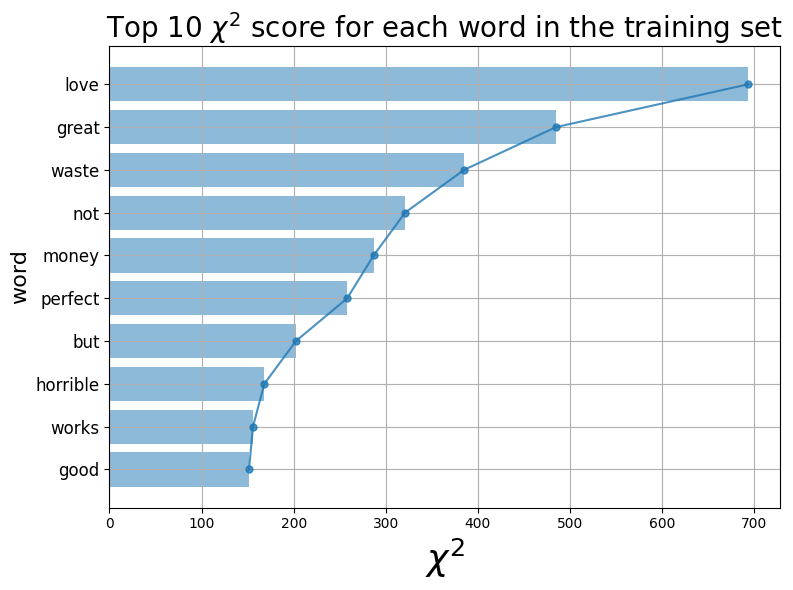

In [ ]:
find_chi_2(df_beauty_balanced, 10)

En el caso del dataset de salud obtenemos básicamente las mismas palabras.

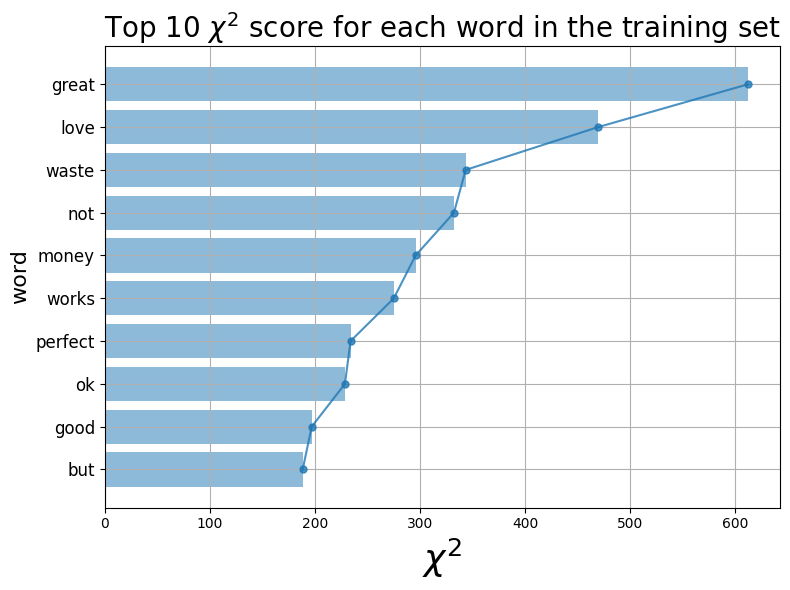

In [ ]:
find_chi_2(df_health_balanced, 10)

En el dataset de música digital vems que aparecen otras palabras curiosas, tales como 'bootleg' que indica la práctica de vender grabaciones ilegalmente. Curioso.

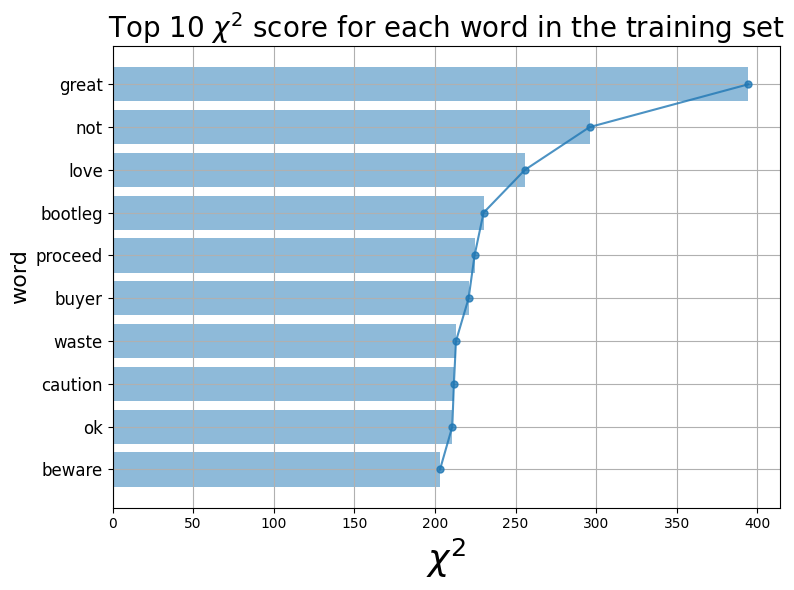

In [ ]:
find_chi_2(df_digital_balanced, 10)

## Vistazo a los embeddings

Habrá tiempo de centrarse en los embeddings más adelante, pero podemos echar un primer vistazo a los que podemos generar con los dataset que tenemos.

Comenzamos asegurándonos de que contamos con las libreria apropiadas.

In [ ]:
!pip install gensim
#Ejercicio de aplicación con Word2Vec
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 59.5 MB/s eta 0:00:00


In [ ]:
import multiprocessing

In [ ]:
cores = multiprocessing.cpu_count() # Contamos el número de cores en el ordenador
print (cores)

2


Podemos iniciar el cálculo de los embeddings instanciando un objeto de Word2Vec, con unos parámetros normales.

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=200,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [ ]:
from time import time  # Tiempo de las operaciones

El siguiente paso es la construcción del vocabulario, algo que no lleva mucho tiempo.

In [ ]:
t = time()
sent = [row.split() for row in df_digital_balanced['text'][0:10000]]
w2v_model.build_vocab(sent, progress_per=10000)

print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))

Tiempo para construir el vocabulario: 0.03 mins


In [ ]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.key_to_index)))

Vocabulario compuesto por 3431 palabras


Por último, toca entrenar el modelo, algo que lleva algo más de tiempo.

In [ ]:
t = time()

w2v_model.train(sent, total_examples = w2v_model.corpus_count, epochs = 15, report_delay = 1)


print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.44 mins


Con todo, como hemos hecho anteriormente, podemos reunir los tres pasos imprescindibles en una función, que llamamos find_model_w2v.

In [ ]:
def find_model_w2v(df, n):

  w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=200,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

  t = time()
  sent = [row.split() for row in df['text'][0:n]]
  w2v_model.build_vocab(sent, progress_per=10000)

  print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))
  print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.key_to_index)))

  t = time()

  w2v_model.train(sent, total_examples = w2v_model.corpus_count, epochs = 15, report_delay = 1)
  print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

  return w2v_model


Aplicamos la función a los datasets completos, con sus 30.000 filas, comenzando por el de música digital, en su columna de 'text'.

In [ ]:
w2v_model = find_model_w2v(df_digital_balanced, 30000)

Tiempo para construir el vocabulario: 0.04 mins
Vocabulario compuesto por 8473 palabras
Time to train the model: 1.52 mins


Podemos ver ahora los embeddings más cercanos a la palabra 'sound', que resulta ser 'sound,', 'Sound' y 'sounds', lo cual prueba que tendremos que hacer un buen preprocesamiento.

In [ ]:
w2v_model.wv.most_similar(positive=["sound"])

[('sound,', 0.5895190834999084),
 ('muffled', 0.5825273394584656),
 ('Sound', 0.5800644159317017),
 ('sounds', 0.5740811228752136),
 ('poor,', 0.5688562989234924),
 ('mixing', 0.5660566091537476),
 ('sounding', 0.5542853474617004),
 ('muddy', 0.5374141335487366),
 ('suffer', 0.5329669713973999),
 ('sounded', 0.5245766639709473)]

La falta de preprocesamiento afecta también a 'song', aunque sí que se encuantran palabras interesantes, como 'remix', por ejemplo.

In [ ]:
w2v_model.wv.most_similar(positive=["song"])

[('track', 0.697210431098938),
 ('song,', 0.6861895322799683),
 ('track,', 0.6578174233436584),
 ('song.', 0.6263589859008789),
 ('tune', 0.6000396013259888),
 ('track.', 0.5667519569396973),
 ('tune,', 0.5579543709754944),
 ('remix', 0.550878643989563),
 ('single', 0.5350388884544373),
 ('songs,', 0.531024694442749)]

En el caso de 'style' y 'guitar' nos encontramos con el mismo fenómeno, aunque las similitudes (coseno) son mayores.

In [ ]:
w2v_model.wv.most_similar(positive=["style"])

[('roots', 0.6729399561882019),
 ('style,', 0.6664454340934753),
 ('trademark', 0.6545186638832092),
 ('approach', 0.6483633518218994),
 ('approach.', 0.618984580039978),
 ('craft', 0.6049148440361023),
 ('songwriting,', 0.6024453043937683),
 ('fusion', 0.6012475490570068),
 ('organic', 0.600361168384552),
 ('compositional', 0.5991835594177246)]

In [ ]:
w2v_model.wv.most_similar(positive=["guitar"])

[('bass', 0.7815951704978943),
 ('keyboard', 0.7656522393226624),
 ('licks', 0.7511233687400818),
 ('solos', 0.7491785883903503),
 ('guitars', 0.7489640116691589),
 ('slide', 0.74800044298172),
 ('keyboards', 0.7413619756698608),
 ('riffs', 0.7389691472053528),
 ('guitar,', 0.7351232171058655),
 ('electric', 0.7343803644180298)]

Podemos hacer lo mismo con los otros dos datasets, comenzando con el de salud. En ambos casos se pone de manifiesto que su vocabulario es de menor tamaño, y que, por lo tanto, al modelo le es más sencillo calcular las similitudes, siendo menores los tiempos de ejecución, y mayores los cosenos obtenidos.

In [ ]:
w2v_model = find_model_w2v(df_health_balanced, 30000)

Tiempo para construir el vocabulario: 0.02 mins
Vocabulario compuesto por 4185 palabras
Time to train the model: 0.63 mins


In [ ]:
w2v_model.wv.most_similar(positive=["health"])

[('digestive', 0.9212417602539062),
 ('immune', 0.9168553352355957),
 ('benefits', 0.9133509397506714),
 ('gut', 0.8983665704727173),
 ('health.', 0.8899138569831848),
 ('diet', 0.8731399178504944),
 ('bacteria', 0.8598745465278625),
 ('beneficial', 0.8586785197257996),
 ('cancer', 0.8463438749313354),
 ('allergies', 0.8355945944786072)]

In [ ]:
w2v_model.wv.most_similar(positive=["blood"])

[('pressure.', 0.8341320753097534),
 ('increase', 0.8174241185188293),
 ('levels', 0.8034442663192749),
 ('pressure', 0.8016767501831055),
 ('inflammation', 0.7590628266334534),
 ('focus', 0.7577472925186157),
 ('fat', 0.7551394104957581),
 ('heart', 0.7491120100021362),
 ('intensity', 0.7362732887268066),
 ('nerve', 0.7315496206283569)]

In [ ]:
w2v_model.wv.most_similar(positive=["smell"])

[('smell.', 0.8628367781639099),
 ('chemical', 0.8270236849784851),
 ('scent', 0.8215514421463013),
 ('smell,', 0.821207582950592),
 ('taste', 0.7900630235671997),
 ('nasty', 0.7859839200973511),
 ('smoke', 0.7811797261238098),
 ('smelled', 0.7799789905548096),
 ('smells', 0.7740880250930786),
 ('tasted', 0.7714694738388062)]

Terminamos el Ejercicio 1 con los embeddings del dataset de belleza.

In [ ]:
w2v_model = find_model_w2v(df_beauty_balanced, 30000)

Tiempo para construir el vocabulario: 0.01 mins
Vocabulario compuesto por 3713 palabras
Time to train the model: 0.54 mins


In [ ]:
w2v_model.wv.most_similar(positive=["skin"])

[('skin,', 0.8820006847381592),
 ('skin.', 0.8536165356636047),
 ('oily', 0.8534896373748779),
 ('face', 0.8490455150604248),
 ('pores', 0.8426918983459473),
 ('greasy', 0.841962993144989),
 ('irritated', 0.8334684371948242),
 ('feeling', 0.819257915019989),
 ('redness', 0.8128172755241394),
 ('acne', 0.8108993768692017)]

In [ ]:
w2v_model.wv.most_similar(positive=["product"])

[('product,', 0.7771305441856384),
 ('item', 0.701262354850769),
 ('product.', 0.6950365304946899),
 ('formula.', 0.6456140279769897),
 ('reviews,', 0.6446147561073303),
 ('purchase,', 0.6418024301528931),
 ('stuff', 0.6335608959197998),
 ('item.', 0.6263476014137268),
 ('serum.', 0.6214549541473389),
 ('writing', 0.6213911175727844)]

In [ ]:
w2v_model.wv.most_similar(positive=["look"])

[('looks', 0.6702640652656555),
 ('blend', 0.6676206588745117),
 ('weren’t', 0.6572871208190918),
 ('fuller', 0.6480208039283752),
 ('fake', 0.6325451135635376),
 ('look.', 0.6272097229957581),
 ('looked', 0.6269144415855408),
 ('look,', 0.6236741542816162),
 ('aren’t', 0.6180140376091003),
 ('natural.', 0.6130877137184143)]

Fin del Ejercicio 1.